In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



# Introduction 


### Competition Objective

> In this competition, you’ll identify melanoma in images of skin lesions. In particular, you’ll use images within the same patient and determine which are likely to represent a melanoma. Using patient-level contextual information may help the development of image analysis tools, which could better support clinical dermatologists.

You need to predict the probability of Melanoma given an iamge and a few other tabular fields. THe evaluation metric is ROC AUC

 
### What is Melanoma?

> Melanoma, also known as malignant melanoma, is a type of skin cancer that develops from the pigment-producing cells known as melanocytes. Melanomas typically occur in the skin but may rarely occur in the mouth, intestines or eye (uveal melanoma). In women, they most commonly occur on the legs, while in men they most commonly occur on the back. About 25% of melanomas develop from moles.Changes in a mole that can indicate melanoma include an increase in size, irregular edges, change in color, itchiness or skin breakdown.
> 

### How is Melanoma typically diagnosed?
- Looking at the area in question is the most common method of suspecting a melanoma.
- Moles that are irregular in color or shape are typically treated as candidates. 
- ABCDE Rule is commonly used in assessment

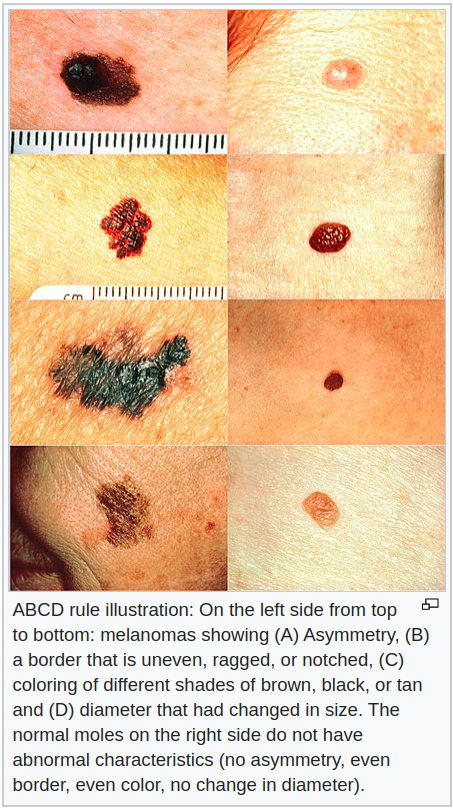

Source: https://en.wikipedia.org/wiki/Melanoma#Diagnosis 


## Section 1: Train / Test Sample
- Train set is roughly 3 times test set 
- "Benign_malignant" and "diagnosis" columns are present in Train data only, so likely not useful

In [ ]:
train = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

print('Train: ', train.shape)
print('Test: ', test.shape)

In [ ]:
train.sample(5)

In [ ]:
test.sample(5)

> ## Section 2: Target Distribution
- ~98% images have target =0 (read heavy class imbalance)
- Target is not at the patient level, but at the image level (Same patient can have some images with target=0 and some with target=1)

In [ ]:

fig = px.histogram(train, 'target', histnorm='probability', height=400, width=600)
fig.update_layout(
        xaxis=dict(
            tickmode='array',
            tickvals=[0,1]
        ),
        yaxis_title = '% Images',
        xaxis_title = 'Target',

        bargap=0.7)
fig.show()

## Section 3: Patient - target and # image Stats
- Train set contains data of about 2K patients. Roughly 1/5th of them have cancer and rest do not
- Test data has ~700 unique patients
- All the patients have 2+ images
- Majority of the patients have <10 images, but there are quite a few who have a lot more
- No appreciable difference in Avg. # of images for patients with and without the cancer 
- No appreciable difference in Avg. # of images in Train data vs Test data 

In [ ]:
train['has_cancer'] = train.groupby('patient_id')['target'].transform('max')
patient_data = train[['patient_id', 'has_cancer']].drop_duplicates()
fig = px.histogram(patient_data, 'has_cancer', height=400, width=600)
fig.update_layout(
        xaxis=dict(
            tickmode='array',
            tickvals=[0,1]
        ),
        yaxis_title = '# Patients',
        xaxis_title = 'Has Cancer',

        bargap=0.7)

In [ ]:
patient_image_cnt = train.groupby(['patient_id'])['image_name'].count().reset_index().rename(columns={'image_name': 'num_images'})
fig = go.Figure()
trace0 = go.Histogram(
    x=patient_image_cnt['num_images'],    
    autobinx=True
)

fig.add_trace(trace0)

fig.update_layout(
        yaxis_title = '<b># Patients</b>',
        xaxis_title = '<b># Images</b>',
        title='Train Data',
    height=400,
    )

fig.show()

In [ ]:
patient_image_cnt = test.groupby(['patient_id'])['image_name'].count().reset_index().rename(columns={'image_name': 'num_images'})
fig = go.Figure()
trace0 = go.Histogram(
    x=patient_image_cnt['num_images'],    
    autobinx=True
)

fig.add_trace(trace0)

fig.update_layout(
        yaxis_title = '<b># Patients</b>',
        xaxis_title = '<b># Images</b>',
    height=400,
    title = 'Test Data'

    )

fig.show()

In [ ]:
patient_image_cnt = train.groupby(['patient_id', 'has_cancer'])['image_name'].count().reset_index().rename(columns={'image_name': 'num_images'})
patient_image_cnt.groupby('has_cancer')['num_images'].mean()

## Section 4: Sex, Age, Anatomy Site - Frequency Distribution 
- Roughly similar distribution of Sex and Age in train / test
- Slighty Higher % of males in both Train / Test


In [ ]:
train_demo = train[['patient_id', 'sex', 'age_approx']].drop_duplicates()
test_demo = test[['patient_id', 'sex', 'age_approx']].drop_duplicates()

In [ ]:
fig = go.Figure()

trace0 = go.Histogram(
    x=train_demo['sex'],    
    autobinx=True,
    name='Train'
)
trace1 = go.Histogram(
    x=test_demo['sex'],    
    autobinx=True,
    name='Test'
)

fig.add_trace(trace0)
fig.add_trace(trace1)

fig.update_layout(
        yaxis_title = 'Count',
        xaxis_title = 'Sex',
    barmode='group',
    bargap=0.5,
    height=400, width=600
    )

fig.show()

In [ ]:
fig = go.Figure()

trace0 = go.Histogram(
    x=train_demo['age_approx'],    
    autobinx=True,
    name='Train'
)
trace1 = go.Histogram(
    x=test_demo['age_approx'],    
    autobinx=True,
    name='Test'
)

fig.add_trace(trace0)
fig.add_trace(trace1)

fig.update_layout(
        yaxis_title = 'Count',
        xaxis_title = 'Age',
    barmode='group',
    )

fig.show()

In [ ]:
fig = go.Figure()

trace0 = go.Histogram(
    x=train['anatom_site_general_challenge'],    
    autobinx=True,
    name='Train'
)
trace1 = go.Histogram(
    x=test['anatom_site_general_challenge'],    
    autobinx=True,
    name='Test'
)

fig.add_trace(trace0)
fig.add_trace(trace1)

fig.update_layout(
        yaxis_title = 'Count',
        xaxis_title = 'anatom_site_general_challenge',
    barmode='group',
    )

fig.show()

## Section 5: Sex, Age, Anatomy Site - Relationship with Target
- There is decent variation in probability of patient having cancer by sex, age and anatomy
- Wonder if image level prediction should be influenced by these patient level stats

In [ ]:
train_anatom = train.groupby('anatom_site_general_challenge')['target'].mean().reset_index()
px.bar(train_anatom, 'anatom_site_general_challenge', 'target')

In [ ]:
train_demo = train[['patient_id', 'sex', 'has_cancer']].drop_duplicates().groupby('sex')['has_cancer'].mean().reset_index()
px.bar(train_demo, 'sex', 'has_cancer')

In [ ]:
train_demo = train[['patient_id', 'age_approx', 'has_cancer']].drop_duplicates().groupby('age_approx')['has_cancer'].mean().reset_index()
px.bar(train_demo, 'age_approx', 'has_cancer')

## Section 6 - Image Visualization 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 

def show_images(images, cols = 1, titles = None):
    # https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        #if image.ndim == 2:
        #    plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

### Train Images Target = 0

In [ ]:
image_list = train[train['target'] == 0].sample(4)['image_name']
image_all=[]
for image_id in image_list:
    image_file = f'/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+image_id+'.jpg' 
    img = np.array(Image.open(image_file))
    image_all.append(img)
show_images(image_all, cols=1)

### Train Images Target =1

In [ ]:
image_list = train[train['target'] == 1].sample(4)['image_name']
image_all=[]
for image_id in image_list:
    image_file = f'/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+image_id+'.jpg' 
    img = np.array(Image.open(image_file))
    image_all.append(img)
show_images(image_all, cols=1)

### Test Images

In [ ]:
image_list = test.sample(4)['image_name']
image_all=[]
for image_id in image_list:
    image_file = f'/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'+image_id+'.jpg' 
    img = np.array(Image.open(image_file))
    image_all.append(img)
show_images(image_all, cols=1)